# Setup

In [54]:
# Starts the autoreload extension, which allows editing the .py files with the notebook running and automatically imports the latest changes

%load_ext autoreload
%autoreload 2

# Imports all the libraries used

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, confusion_matrix
from umap import UMAP
from tqdm import tqdm

from functools import partial

import jax
from jax import numpy as jnp
import haiku as hk
import optax

import resnet
import data
import train

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
NUM_CLASSES = 4
SEED = 12
BATCH_SIZE = 128

classes = ['Normal', 'Pneumonia-Bacterial', 'COVID-19', 'Pneumonia-Viral']

rng = jax.random.PRNGKey(SEED)

## Data

In [3]:
(x_train, y_train), (x_test, y_test) = data.load_data('.', rng, test_size = 0.1)

x_all = np.concatenate([x_test, x_train])
y_all = np.concatenate([y_test, y_train])

## Model functions

In [4]:
def forward(batch, is_training, return_representation = False):
    return resnet.ResNet18(num_classes = NUM_CLASSES, resnet_v2 = True)(batch, is_training, return_representation = return_representation)

net = hk.transform_with_state(forward)
schedule = optax.cosine_decay_schedule(1e-1, 30 * (len(x_train) // BATCH_SIZE))
optim = optax.adamw(schedule, weight_decay = 1e-3)

# Duplicates Detector

In [14]:
# Gets functions for the model
init_fn, loss_fn, grad_fn, update, predict, evaluate, train_epoch = train.get_network_fns(net, optim, BATCH_SIZE)

# Initializes parameters and state
params, state, optim_state = init_fn(rng)

# Train the model for 30 epochs
for i in range(30):
    params, state, optim_state = train_epoch(params, state, optim_state, x_train, y_train, x_test, y_test)

100%|█████████████████████████████████| 64/64 [00:05<00:00, 10.99it/s, loss=0.14, acc=0.95, val loss=0.35, val acc=0.86]


## Similarity Filter

In [15]:
# Finds the latent vectorsfor the entire dataset
reprs = predict(params, state, x_all, return_representation = True)
reprs = reprs.reshape(reprs.shape[0], -1)

100%|███████████████████████████████████████████████████████████████████████████████████| 72/72 [00:12<00:00,  5.91it/s]


In [16]:
# Given two matrices of shapes [n, dim] and [m, dim], returns a matrix [n, m] with all cosine similarities between the vectors

@partial(jax.vmap, in_axes = (None, 0))
@partial(jax.vmap, in_axes = (0, None))

def sim(x,y):
    return jnp.dot(x,y) / jnp.sqrt(jnp.dot(x,x) * jnp.dot(y,y))

In [17]:
# Finds the cosine similarity between all images in the dataset
sims = sim(reprs, reprs)

# Removes the diagonal of the matrix, since all images have a similarity of 1 with themselves
sims = sims - np.eye(sims.shape[0])

In [18]:
# Set of images to be removed
remove = set()

# For each image not yet removed, add all of its duplicates to the removed set

for i in tqdm(range(len(x_all))):
    if i not in remove:
        remove = remove.union(set(list(np.nonzero(sims[i] > 0.99)[0])))

print('Removed images:', len(remove))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9208/9208 [00:57<00:00, 160.58it/s]

Removed images: 2653


In [19]:
# Finds the indices of the images that will not to be removed
keep = set(range(len(x_all))).difference(remove)
keep = np.array(list(keep))

# These indices are for the x_all and y_all arrays.
# The tensor x_all, for example, is the concatenation of x_test and x_train

# Converts keep indices to be used in the train and test tensors
keep_test = keep[keep < len(x_test)]
keep_train = keep[keep >= len(x_test)] - len(x_test)

In [20]:
# Removes the duplicates from the train and test sets

x_test_curated = x_test[keep_test]
y_test_curated = y_test[keep_test]

x_train_curated = x_train[keep_train]
y_train_curated = y_train[keep_train]

# Curated Dataset Training

In [23]:
# Initializes parameters and state
params_curated, state_curated, optim_state_curated = init_fn(jax.random.split(rng)[0])

# Gets functions for the model
init_fn, loss_fn, grad_fn, update, predict, evaluate, train_epoch = train.get_network_fns(net, optim, BATCH_SIZE)

# Train the model for 30 epochs on the curated dataset
for i in range(30):
    params_curated, state_curated, optim_state_curated = train_epoch(params_curated, state_curated, optim_state_curated, x_train_curated, y_train_curated, x_test_curated, y_test_curated)

100%|█████████████████████████████████| 44/44 [00:03<00:00, 11.94it/s, loss=0.35, acc=0.86, val_loss=0.64, val_acc=0.80]


# Results

In [26]:
# Predicts the classes for the test set using the models trained on the original and on the curated dataset
y_pred = predict(params, state, x_test)
y_pred_curated = predict(params_curated, state_curated, x_test_curated)

100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 17.14it/s]


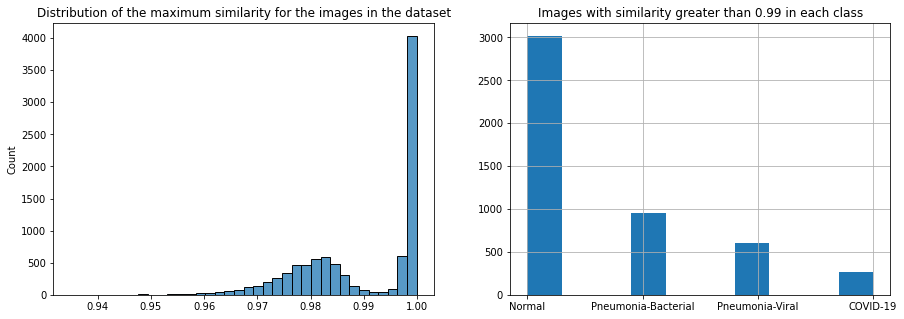

In [28]:
fig, axs = plt.subplots(1, 2, figsize = (15,5))
    
sn.histplot(sims.max(0), ax = axs[0]).set(title = 'Distribution of the maximum similarity for the images in the dataset')

plt.title('Images with similarity greater than 0.99 in each class')
pd.Series(y_all[sims.max(0) > 0.99].argmax(1)).map(dict(zip(range(4), classes))).hist()
plt.show()

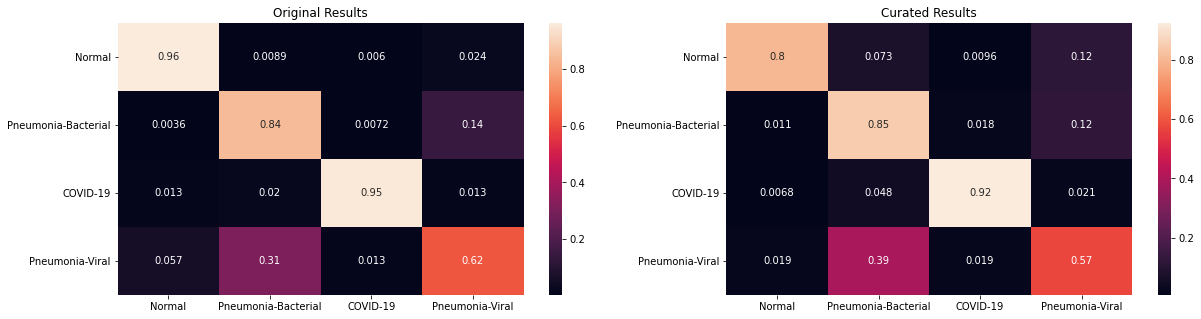

In [29]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5))
sn.heatmap(confusion_matrix(y_test.argmax(1), y_pred.argmax(1), normalize = 'true'), ax = axs[0], annot = True, xticklabels = classes, yticklabels = classes).set(title = 'Original Results')
sn.heatmap(confusion_matrix(y_test_curated.argmax(1), y_pred_curated.argmax(1), normalize = 'true'), ax = axs[1], annot = True, xticklabels = classes, yticklabels = classes).set(title = 'Curated Results');

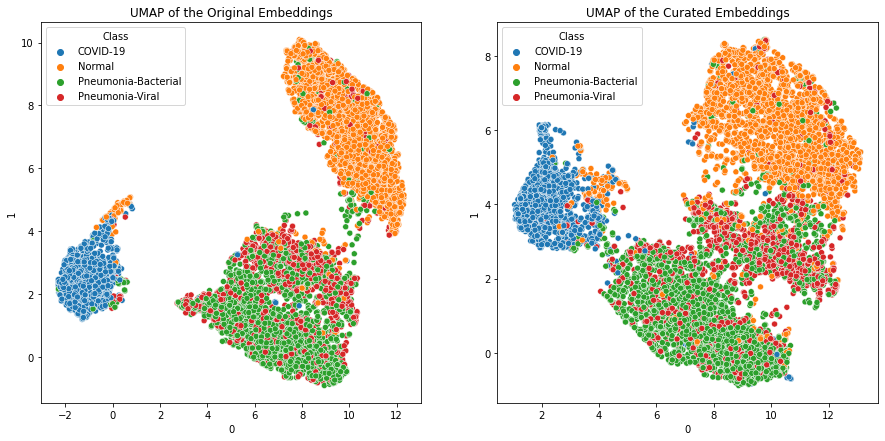

In [57]:
fig, axs = plt.subplots(1,2, figsize = (15,7))

reprs_curated = predict(params_curated, state_curated, x_all, return_representation = True, verbose = False)
reprs_curated = reprs_curated.reshape(reprs_curated.shape[0], -1)

umap = UMAP().fit_transform(reprs)
umap_curated = UMAP().fit_transform(reprs_curated)

df = pd.DataFrame(umap)
df['class_id'] = y_all.argmax(1)
df['Class'] = df['class_id'].map(lambda x: ['Normal', 'Pneumonia-Bacterial', 'COVID-19', 'Pneumonia-Viral'][x])

sn.scatterplot(ax = axs[0], x = df[0], y = df[1], hue = df['Class']).set(title = 'UMAP of the Original Embeddings')

df = pd.DataFrame(umap_curated)
df['class_id'] = y_all.argmax(1)
df['Class'] = df['class_id'].map(lambda x: ['Normal', 'Pneumonia-Bacterial', 'COVID-19', 'Pneumonia-Viral'][x])

sn.scatterplot(ax = axs[1], x = df[0], y = df[1], hue = df['Class']).set(title = "UMAP of the Curated Embeddings");